<a href="https://colab.research.google.com/github/nv-hiep/Autoencoders/blob/main/Autoencoders_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Reshape, Input
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, Dropout, ActivityRegularization
from keras.layers import LSTM, RepeatVector, TimeDistributed, GaussianNoise

In [ ]:
# Where to save the figures
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'autoencoders'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    # plt.axis('off')

# Stacked Autoencoder

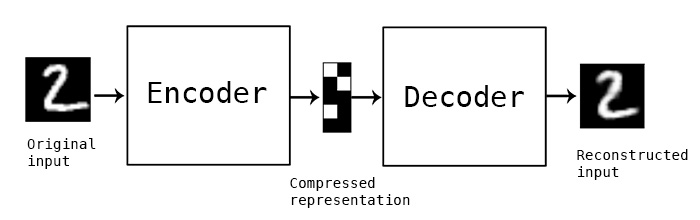

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train_full = X_train_full / 255.
X_test       = X_test / 255.

In [ ]:
print('X_train_full.shape: ', X_train_full.shape)
print('y_train_full.shape: ', y_train_full.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train_full.shape:  (60000, 28, 28)
y_train_full.shape:  (60000,)
X_test.shape:  (10000, 28, 28)
y_test.shape:  (10000,)


In [ ]:
train_size = 50_000

In [ ]:
X_train = X_train_full[:train_size]
X_valid = X_train_full[train_size:]

y_train = y_train_full[:train_size]
y_valid = y_train_full[train_size:]

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_valid.shape: ', X_valid.shape)
print('y_valid.shape: ', y_valid.shape)

X_train.shape:  (50000, 28, 28)
y_train.shape:  (50000,)
X_valid.shape:  (10000, 28, 28)
y_valid.shape:  (10000,)


Just like other neural networks we have discussed, autoencoders can have multiple hidden layers. In this case they are called stacked autoencoders (or deep autoencoders). Adding more layers helps the autoencoder learn more complex codings. That said, one must be careful not to make the autoencoder too powerful. Imagine an encoder so powerful that it just learns to map each input to a single arbitrary number (and the decoder learns the reverse mapping). Obviously such an autoencoder will reconstruct the training data perfectly, but it will not have learned any useful data representation in the process (and it is unlikely to generalize well to new instances).

The architecture of a stacked autoencoder is typically symmetrical with regard to the central hidden layer (the coding layer). To put it simply, it looks like a sandwich. For example, an autoencoder for MNIST (introduced in Chapter 3) may have 784 inputs, followed by a hidden layer with 100 neurons, then a central hidden layer of 30 neurons, then another hidden layer with 100 neurons, and an output layer with 784 neurons. This stacked autoencoder is represented in Figure 17-3.

Build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders):

Output Layer (Units: 784) -> Reconstruction

Hidden 3 (Units: 100)

Hidden 2 (Units: 30) -> Codings

Hidden 1 (Units: 100)

Input Layer (Units: 784) 

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = Sequential()
encoder.add(Flatten(input_shape=[28,28]))
encoder.add(Dense(100, activation='selu'))
encoder.add(Dense(30, activation='selu'))

decoder = Sequential()
decoder.add(Dense(100, activation='selu', input_shape=[30]))
decoder.add(Dense(28*28, activation='sigmoid'))
decoder.add(Reshape([28,28]))

autoencoder = Sequential([encoder, decoder])
autoencoder.compile(loss='binary_crossentropy', optimizer=SGD(0.15), metrics=['binary_accuracy'])

In [ ]:
history = autoencoder.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1563/1563 [==============================] - 19s 3ms/step - loss: 0.5264 - binary_accuracy: 0.4442 - val_loss: 0.3708 - val_binary_accuracy: 0.4937
Epoch 2/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3640 - binary_accuracy: 0.4977 - val_loss: 0.3480 - val_binary_accuracy: 0.4974
Epoch 3/20
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3417 - binary_accuracy: 0.5019 - val_loss: 0.3321 - val_binary_accuracy: 0.5000
Epoch 4/20
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3276 - binary_accuracy: 0.5044 - val_loss: 0.3237 - val_binary_accuracy: 0.5009
Epoch 5/20
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3212 - binary_accuracy: 0.5039 - val_loss: 0.3191 - val_binary_accuracy: 0.5015
Epoch 6/20
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3166 - binary_accuracy: 0.5049 - val_loss: 0.3160 - val_binary_accuracy: 0.5021
Epoch 7/20
1563/1563 [=============================

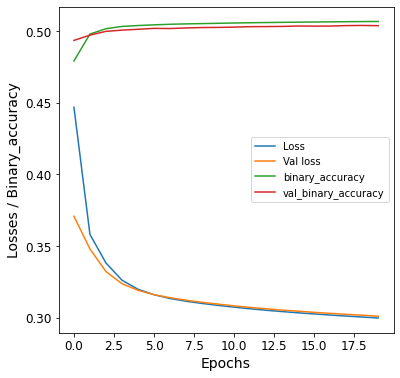

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')

plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')

plt.xlabel('Epochs')
plt.ylabel('Losses / Binary_accuracy')

plt.legend()
plt.show()

In [ ]:
def show_reconstructions(model, images=X_test, n_images=5):
  '''
  First row: real images
  Second row: reconstructed images
  '''
  reconstructions = model.predict(images[:n_images])

  plt.figure(figsize=(n_images * 1.5, 3))
  # plt.title('Image reconstruction from Stacked Autoencoder')
  for img_id in range(n_images):
    plt.subplot(2, n_images, 1 + img_id)
    plot_image(images[img_id])
    plt.subplot(2, n_images, 1 + n_images + img_id)
    plot_image(reconstructions[img_id])
  plt.show()

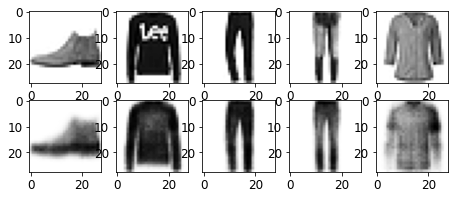

In [ ]:
show_reconstructions(autoencoder, images=X_test)
# save_fig('reconstruction_plot')

# Training one Autoencoder at a Time

It is possible to train one shallow autoencoder at a time, then stack all of them into a single stacked autoencoder.

During the first phase of training, the first autoencoder learns to reconstruct the inputs. Then we encode the whole training set using this first autoencoder, and this gives us a new (compressed) training set. We then train a second autoencoder on this new dataset. This is the second phase of training. Finally, we build a big sandwich using all these autoencoders

In [ ]:
def train_autoencoder(n_neurons, X_train, X_valid,
                      loss_fcn, optimizer, n_epochs=10,
                      output_activation=None, metrics=None):
  
  n_inputs = X_train.shape[-1]

  encoder = Sequential()
  encoder.add( Dense(n_neurons, activation='selu', input_shape=[n_inputs]) )
  
  decoder = Sequential()
  decoder.add( Dense(n_inputs, activation=output_activation) )
  
  autoencoder = Sequential([encoder, decoder])

  autoencoder.compile(optimizer=optimizer, loss=loss_fcn, metrics=metrics)
  autoencoder.fit(X_train, X_train, epochs=n_epochs, validation_data=(X_valid, X_valid))

  return encoder, decoder, encoder(X_train), encoder(X_valid)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)

enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(100,
                                                           X_train_flat,
                                                           X_valid_flat,
                                                           'binary_crossentropy',
                                                           SGD(learning_rate=1.5),
                                                           output_activation='sigmoid',
                                                           metrics=['binary_accuracy'])

enc2, dec2, _, _ = train_autoencoder(30,
                                     X_train_enc1,
                                     X_valid_enc1,
                                     'mse',
                                     SGD(learning_rate=0.05),
                                     output_activation='selu')

Epoch 1/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.4007 - binary_accuracy: 0.4881 - val_loss: 0.3132 - val_binary_accuracy: 0.5032
Epoch 2/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3082 - binary_accuracy: 0.5071 - val_loss: 0.3018 - val_binary_accuracy: 0.5046
Epoch 3/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2980 - binary_accuracy: 0.5084 - val_loss: 0.2947 - val_binary_accuracy: 0.5054
Epoch 4/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2913 - binary_accuracy: 0.5095 - val_loss: 0.2899 - val_binary_accuracy: 0.5058
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2877 - binary_accuracy: 0.5088 - val_loss: 0.2866 - val_binary_accuracy: 0.5061
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2843 - binary_accuracy: 0.5095 - val_loss: 0.2843 - val_binary_accuracy: 0.5063
Epoch 7/10
1563/1563 [==============================

Stack All the autoencoders

In [ ]:
stacked_autoencoder = Sequential([
                                Flatten(input_shape=[28, 28]),
                                enc1, enc2,
                                dec2, dec1,
                                Reshape([28, 28])
                                ])

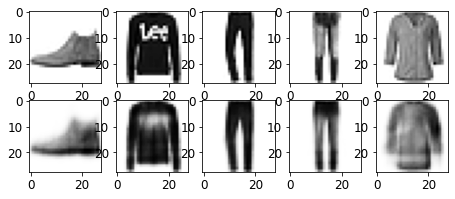

In [ ]:
# Plot the reconstructed images
show_reconstructions(stacked_autoencoder, images=X_test)
plt.show()

# Convolutional Autoencoders

If you are dealing with images, then the autoencoders we have seen so far will not work well (unless the images are very small): Convolutional neural networks are far better suited than dense networks to work with images. So if you want to build an autoencoder for images (e.g., for unsupervised pretraining or dimensionality reduction), you will need to build a convolutional autoencoder.

The encoder is a regular CNN composed of convolutional layers and pooling layers. It typically reduces the spatial dimensionality of the inputs (i.e., height and width) while increasing the depth (i.e., the number of feature maps). The decoder must do the reverse (upscale the image and reduce its depth back to the original dimensions), and for this you can use transpose convolutional layers (alternatively, you could combine upsampling layers with convolutional layers).

Here is a simple convolutional autoencoder for Fashion MNIST:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = Sequential()
conv_encoder.add( Reshape([28,28,1], input_shape=[28,28] ) )
conv_encoder.add( Conv2D(16, kernel_size=3, padding='same', activation='selu') )
conv_encoder.add( MaxPool2D(pool_size=2) )
conv_encoder.add( Conv2D(32, kernel_size=3, padding='same', activation='selu') )
conv_encoder.add( MaxPool2D(pool_size=2) )
conv_encoder.add( Conv2D(64, kernel_size=3, padding='same', activation='selu') )
conv_encoder.add( MaxPool2D(pool_size=2) )
# 28x28 -> 26x26 -> 13x13 -> 11x11 -> 5x5 -> 3x3
# Output shape: 3,3,64

conv_decoder = Sequential()
conv_decoder.add( Conv2DTranspose(32, kernel_size=3, strides=2, padding='valid', activation='selu', input_shape=[3,3,64]) )
conv_decoder.add( Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='selu') )
conv_decoder.add( Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid') )
conv_decoder.add( Reshape([28,28]) )

conv_autoencoder = Sequential([conv_encoder, conv_decoder])

conv_autoencoder.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=1.0), metrics=['binary_accuracy'])

In [ ]:
history = conv_autoencoder.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))

Epoch 1/5
1563/1563 [==============================] - 87s 5ms/step - loss: 0.3420 - binary_accuracy: 0.5035 - val_loss: 0.2806 - val_binary_accuracy: 0.5060
Epoch 2/5
1563/1563 [==============================] - 7s 5ms/step - loss: 0.2780 - binary_accuracy: 0.5094 - val_loss: 0.2753 - val_binary_accuracy: 0.5067
Epoch 3/5
1563/1563 [==============================] - 7s 4ms/step - loss: 0.2719 - binary_accuracy: 0.5100 - val_loss: 0.2710 - val_binary_accuracy: 0.5068
Epoch 4/5
1563/1563 [==============================] - 7s 5ms/step - loss: 0.2685 - binary_accuracy: 0.5106 - val_loss: 0.2712 - val_binary_accuracy: 0.5065
Epoch 5/5
1563/1563 [==============================] - 7s 5ms/step - loss: 0.2672 - binary_accuracy: 0.5096 - val_loss: 0.2700 - val_binary_accuracy: 0.5070


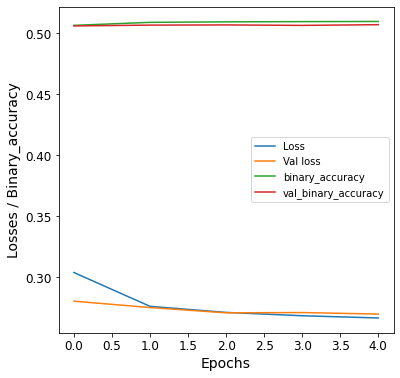

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')

plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')

plt.xlabel('Epochs')
plt.ylabel('Losses / Binary_accuracy')

plt.legend()
plt.show()

In [ ]:
# Convolutional Encoder
conv_encoder.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 64)        

In [ ]:
# Convolutional Decoder
conv_decoder.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_6 (Conv2DTr (None, 7, 7, 32)          18464     
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 14, 14, 16)        4624      
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 28, 28, 1)         145       
_________________________________________________________________
reshape_8 (Reshape)          (None, 28, 28)            0         
Total params: 23,233
Trainable params: 23,233
Non-trainable params: 0
_________________________________________________________________


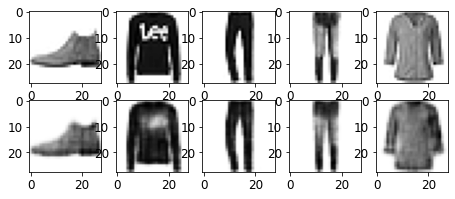

In [ ]:
# Plot the reconstructed images
show_reconstructions(conv_autoencoder, images=X_test)
plt.show()

# Recurrent Autoencoders

If you want to build an autoencoder for sequences, such as time series or text (e.g., for unsupervised learning or dimensionality reduction), then recurrent neural networks (RNN) may be better suited than dense networks. Building a recurrent autoencoder is straightforward: the encoder is typically a sequence-to-vector RNN which compresses the input sequence down to a single vector. The decoder is a vector-to-sequence RNN that does the reverse.

In [ ]:
# Encoder: a sequence-to-vector RNN which compresses the input sequence down to a single vector
recurrent_encoder = Sequential()
recurrent_encoder.add( LSTM(100, return_sequences=True, input_shape=[28,28]) )
recurrent_encoder.add( LSTM(30) )

# Decoder: vector-to-sequence RNN
recurrent_decoder = keras.models.Sequential()
recurrent_decoder.add( RepeatVector(28, input_shape=[30]) )
recurrent_decoder.add( LSTM(100, return_sequences=True) )
recurrent_decoder.add( TimeDistributed(Dense(28, activation='sigmoid')) )

recurrent_autoencoder = Sequential([recurrent_encoder, recurrent_decoder])
recurrent_autoencoder.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(0.1), metrics=['binary_accuracy'])

In [ ]:
recurrent_encoder.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 28, 100)           51600     
_________________________________________________________________
lstm_6 (LSTM)                (None, 30)                15720     
Total params: 67,320
Trainable params: 67,320
Non-trainable params: 0
_________________________________________________________________


In [ ]:
recurrent_decoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_3 (ModuleWrap (None, 28, 30)            0         
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 28, 100)           52400     
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 28, 28)            2828      
Total params: 55,228
Trainable params: 55,228
Non-trainable params: 0
_________________________________________________________________


In [ ]:
recurrent_autoencoder.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_29 (Sequential)   (None, 30)                67320     
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 28, 28)            55228     
Total params: 122,548
Trainable params: 122,548
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = recurrent_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1563/1563 [==============================] - 22s 9ms/step - loss: 0.5623 - binary_accuracy: 0.4669 - val_loss: 0.4449 - val_binary_accuracy: 0.4900
Epoch 2/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.4243 - binary_accuracy: 0.4934 - val_loss: 0.3769 - val_binary_accuracy: 0.4924
Epoch 3/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.3703 - binary_accuracy: 0.4985 - val_loss: 0.3600 - val_binary_accuracy: 0.4952
Epoch 4/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.3558 - binary_accuracy: 0.4993 - val_loss: 0.3501 - val_binary_accuracy: 0.4970
Epoch 5/10
1563/1563 [==============================] - 13s 9ms/step - loss: 0.3483 - binary_accuracy: 0.4990 - val_loss: 0.3481 - val_binary_accuracy: 0.4923
Epoch 6/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.3395 - binary_accuracy: 0.5005 - val_loss: 0.3384 - val_binary_accuracy: 0.4999
Epoch 7/10
1563/1563 [========================

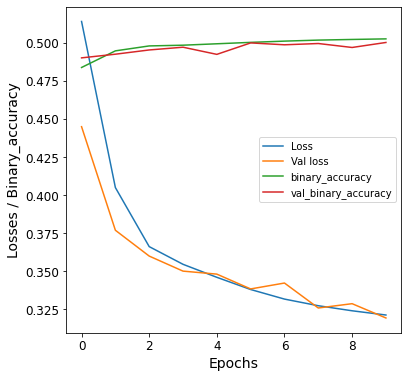

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')

plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')

plt.xlabel('Epochs')
plt.ylabel('Losses / Binary_accuracy')

plt.legend()
plt.show()

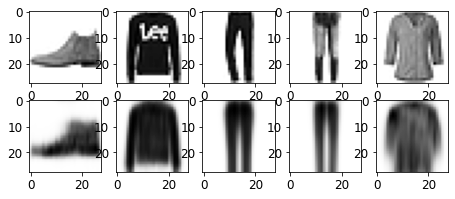

In [ ]:
# Plot the reconstructed images
show_reconstructions(recurrent_autoencoder, images=X_test)
plt.show()

# Denoising Autoencoders

Another way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original, noise-free inputs. This idea has been around since the 1980s (e.g., it is mentioned in Yann LeCun’s 1987 master’s thesis). In a 2008 paper, Pascal Vincent et al. showed that autoencoders could also be used for feature extraction. In a 2010 paper, Vincent et al. introduced stacked denoising autoencoders.

The noise can be pure Gaussian noise added to the inputs, or it can be randomly switched-off inputs, just like in dropout.

The implementation is straightforward: it is a regular stacked autoencoder with an additional Dropout layer applied to the encoder’s inputs (or you could use a GaussianNoise layer instead). Recall that the Dropout layer is only active during training (and so is the GaussianNoise layer):

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = Sequential()
denoising_encoder.add( Flatten(input_shape=[28,28]) )
denoising_encoder.add( GaussianNoise(0.2) )
denoising_encoder.add( Dense(100, activation='selu') )
denoising_encoder.add( Dense(30, activation='selu'))

denoising_decoder = Sequential()
denoising_decoder.add( Dense(100, activation='selu', input_shape=[30]) )
denoising_decoder.add( Dense(28*28, activation='sigmoid') )
denoising_decoder.add( Reshape([28,28]) )

denoising_autoencoder = Sequential([denoising_encoder, denoising_decoder])
denoising_autoencoder.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=1.0), metrics=['binary_accuracy'])

In [ ]:
denoising_encoder.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_19 (Dense)             (None, 30)                3030      
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________


In [ ]:
denoising_decoder.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 100)               3100      
_________________________________________________________________
dense_21 (Dense)             (None, 784)               79184     
_________________________________________________________________
reshape_10 (Reshape)         (None, 28, 28)            0         
Total params: 82,284
Trainable params: 82,284
Non-trainable params: 0
_________________________________________________________________


In [ ]:
denoising_autoencoder.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_34 (Sequential)   (None, 30)                81530     
_________________________________________________________________
sequential_35 (Sequential)   (None, 28, 28)            82284     
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = denoising_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1563/1563 [==============================] - 6s 3ms/step - loss: 0.4054 - binary_accuracy: 0.4843 - val_loss: 0.3190 - val_binary_accuracy: 0.5024
Epoch 2/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3152 - binary_accuracy: 0.5050 - val_loss: 0.3090 - val_binary_accuracy: 0.5022
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3075 - binary_accuracy: 0.5065 - val_loss: 0.3054 - val_binary_accuracy: 0.5043
Epoch 4/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3029 - binary_accuracy: 0.5075 - val_loss: 0.3002 - val_binary_accuracy: 0.5044
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3008 - binary_accuracy: 0.5068 - val_loss: 0.3038 - val_binary_accuracy: 0.5051
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2984 - binary_accuracy: 0.5075 - val_loss: 0.2979 - val_binary_accuracy: 0.5035
Epoch 7/10
1563/1563 [==============================

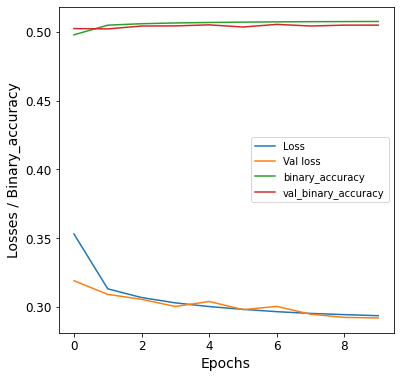

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')

plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')

plt.xlabel('Epochs')
plt.ylabel('Losses / Binary_accuracy')

plt.legend()
plt.show()

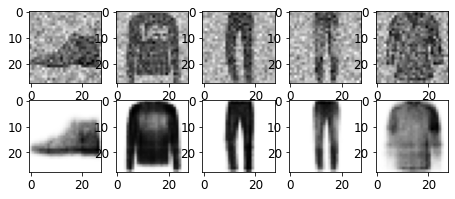

In [ ]:
# Plot the reconstructed images
tf.random.set_seed(42)
np.random.seed(42)

noise = GaussianNoise(0.2)
show_reconstructions(denoising_autoencoder, images=noise(X_test, training=True))
plt.show()

Using dropout:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = Sequential()
dropout_encoder.add( Flatten(input_shape=[28,28]) )
dropout_encoder.add( Dropout(0.5) )
dropout_encoder.add( Dense(100, activation='selu') )
dropout_encoder.add( Dense(30, activation='selu'))

dropout_decoder = Sequential()
dropout_decoder.add( Dense(100, activation='selu', input_shape=[30]) )
dropout_decoder.add( Dense(28*28, activation='sigmoid') )
dropout_decoder.add( Reshape([28,28]) )

dropout_autoencoder = Sequential([dropout_encoder, dropout_decoder])
dropout_autoencoder.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=1.0), metrics=['binary_accuracy'])

In [ ]:
history = dropout_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1563/1563 [==============================] - 6s 3ms/step - loss: 0.4130 - binary_accuracy: 0.4825 - val_loss: 0.3209 - val_binary_accuracy: 0.5017
Epoch 2/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3212 - binary_accuracy: 0.5037 - val_loss: 0.3124 - val_binary_accuracy: 0.5013
Epoch 3/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3142 - binary_accuracy: 0.5048 - val_loss: 0.3080 - val_binary_accuracy: 0.5019
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3095 - binary_accuracy: 0.5060 - val_loss: 0.3046 - val_binary_accuracy: 0.5022
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3075 - binary_accuracy: 0.5053 - val_loss: 0.3018 - val_binary_accuracy: 0.5030
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3051 - binary_accuracy: 0.5061 - val_loss: 0.3008 - val_binary_accuracy: 0.5032
Epoch 7/10
1563/1563 [==============================

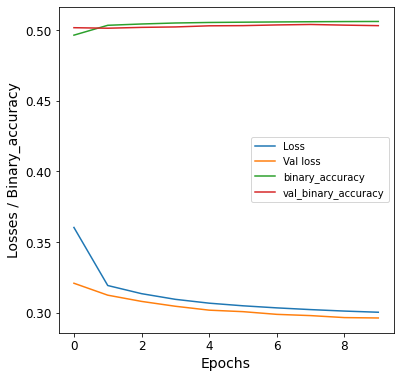

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')

plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')

plt.xlabel('Epochs')
plt.ylabel('Losses / Binary_accuracy')

plt.legend()
plt.show()

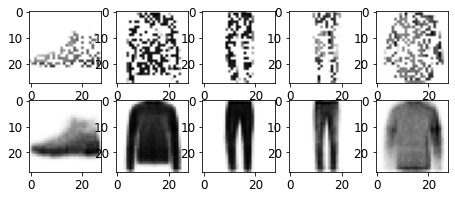

In [ ]:
# Plot the reconstructed images
tf.random.set_seed(42)
np.random.seed(42)

dropout = Dropout(0.5)
show_reconstructions(dropout_autoencoder, images=dropout(X_test, training=True))
plt.show()

# Sparse Autoencoders

Another kind of constraint that often leads to good feature extraction is sparsity: by adding an appropriate term to the cost function, the autoencoder is pushed to reduce the number of active neurons in the coding layer. For example, it may be pushed to have on average only 5% significantly active neurons in the coding layer. This forces the autoencoder to represent each input as a combination of a small number of activations. As a result, each neuron in the coding layer typically ends up representing a useful feature (if you could speak only a few words per month, you would probably try to make them worth listening to).

A simple approach is to use the sigmoid activation function in the coding layer (to constrain the codings to values between 0 and 1), use a large coding layer (e.g., with 300 units), and add some L1 regularization to the coding layer’s activations (the decoder is just a regular decoder):

Let's build a simple stacked autoencoder, so we can compare it to the sparse autoencoders we will build. This time we will use the sigmoid activation function for the coding layer, to ensure that the coding values range from 0 to 1:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = Sequential()
simple_encoder.add( Flatten(input_shape=[28,28]) )
simple_encoder.add( Dense(100, activation='selu') )
simple_encoder.add( Dense(30, activation='sigmoid') ) # ensure that the coding values range from 0 to 1

simple_decoder = Sequential()
simple_decoder.add( Dense(100, activation='selu', input_shape=[30]) )
simple_decoder.add( Dense(28*28, activation='sigmoid') )
simple_decoder.add( Reshape([28,28]) )

simple_autoencoder = Sequential([simple_encoder, simple_decoder])
simple_autoencoder.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=1.), metrics=['binary_accuracy'])

In [ ]:
history = simple_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.4933 - binary_accuracy: 0.4762 - val_loss: 0.3790 - val_binary_accuracy: 0.4941
Epoch 2/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3712 - binary_accuracy: 0.4970 - val_loss: 0.3542 - val_binary_accuracy: 0.4956
Epoch 3/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3468 - binary_accuracy: 0.5006 - val_loss: 0.3367 - val_binary_accuracy: 0.4988
Epoch 4/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3315 - binary_accuracy: 0.5033 - val_loss: 0.3264 - val_binary_accuracy: 0.4998
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3234 - binary_accuracy: 0.5033 - val_loss: 0.3225 - val_binary_accuracy: 0.5018
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3189 - binary_accuracy: 0.5042 - val_loss: 0.3184 - val_binary_accuracy: 0.5015
Epoch 7/10
1563/1563 [==============================

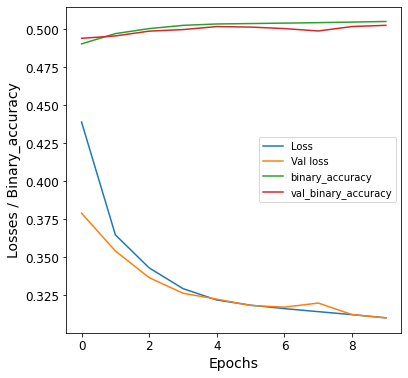

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')

plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')

plt.xlabel('Epochs')
plt.ylabel('Losses / Binary_accuracy')

plt.legend()
plt.show()

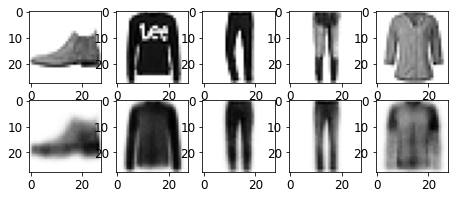

In [ ]:
# Plot the reconstructed images
show_reconstructions(simple_autoencoder, images=X_test)
plt.show()

Let's create a couple functions to print nice activation histograms:

In [ ]:
def plot_percent_hist(ax, data, bins):
  counts, _ = np.histogram(data, bins=bins)
  widths = bins[1:] - bins[:-1]
  x = bins[:-1] + widths / 2
  ax.bar(x, counts / len(data), width=widths*0.8)
  ax.xaxis.set_ticks(bins)
  ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, position: "{}%".format(int(np.round(100 * y)))))
  ax.grid(True)

In [ ]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
  X_valid_codings = encoder(X_valid).numpy()
  activation_means = X_valid_codings.mean(axis=0)
  mean = activation_means.mean()
  bins = np.linspace(0, 1, n_bins + 1)

  fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
  plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
  ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
  ax1.legend(loc="upper center", fontsize=14)
  ax1.set_xlabel("Activation")
  ax1.set_ylabel("% Activations")
  ax1.axis([0, 1, 0, height])
  plot_percent_hist(ax2, activation_means, bins)
  ax2.plot([mean, mean], [0, height], "k--")
  ax2.set_xlabel("Neuron Mean Activation")
  ax2.set_ylabel("% Neurons")
  ax2.axis([0, 1, 0, height])

Let's use these functions to plot histograms of the activations of the encoding layer. The histogram on the left shows the distribution of all the activations. You can see that values close to 0 or 1 are more frequent overall, which is consistent with the saturating nature of the sigmoid function. The histogram on the right shows the distribution of mean neuron activations: you can see that most neurons have a mean activation close to 0.5. Both histograms tell us that each neuron tends to either fire close to 0 or 1, with about 50% probability each. However, some neurons fire almost all the time (right side of the right histogram).

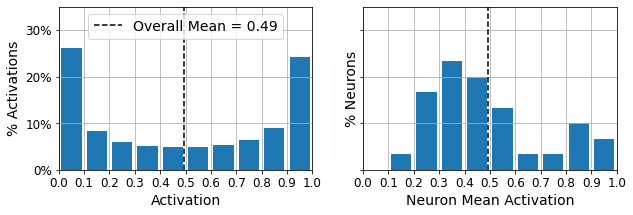

In [ ]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

Now let's add L1 regularization to the coding layer:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

l1_encoder = Sequential()
l1_encoder.add( Flatten(input_shape=[28,28]) )
l1_encoder.add( Dense(100, activation='selu') )
l1_encoder.add( Dense(300, activation='sigmoid') ) # ensure that the coding values range from 0 to 1
l1_encoder.add( ActivityRegularization(l1=1e-3) )
# Alternatively, you could add activity_regularizer=keras.regularizers.l1(1e-3) to the previous layer.

l1_decoder = Sequential()
l1_decoder.add( Dense(100, activation='selu', input_shape=[300]) )
l1_decoder.add( Dense(28*28, activation='sigmoid') )
l1_decoder.add( Reshape([28,28]) )

l1_autoencoder = Sequential([l1_encoder, l1_decoder])
l1_autoencoder.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=1.), metrics=['binary_accuracy'])

This ActivityRegularization layer just returns its inputs, but as a side effect it adds a training loss equal to the sum of absolute values of its inputs (this layer only has an effect during training). Equivalently, you could remove the ActivityRegularization layer and set activity_regularizer=keras.regularizers.l1(1e-3) in the previous layer.

This penalty will encourage the neural network to produce codings close to 0, but since it will also be penalized if it does not reconstruct the inputs correctly, it will have to output at least a few nonzero values. Using the ℓ1 norm rather than the ℓ2 norm will push the neural network to preserve the most important codings while eliminating the ones that are not needed for the input image (rather than just reducing all codings).

In [ ]:
history = l1_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1563/1563 [==============================] - 6s 3ms/step - loss: 0.5040 - binary_accuracy: 0.4862 - val_loss: 0.3810 - val_binary_accuracy: 0.4936
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3757 - binary_accuracy: 0.4972 - val_loss: 0.3651 - val_binary_accuracy: 0.4948
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3608 - binary_accuracy: 0.4989 - val_loss: 0.3534 - val_binary_accuracy: 0.4962
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3490 - binary_accuracy: 0.5009 - val_loss: 0.3479 - val_binary_accuracy: 0.4950
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3415 - binary_accuracy: 0.5007 - val_loss: 0.3388 - val_binary_accuracy: 0.4996
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3350 - binary_accuracy: 0.5021 - val_loss: 0.3333 - val_binary_accuracy: 0.4984
Epoch 7/10
1563/1563 [==============================

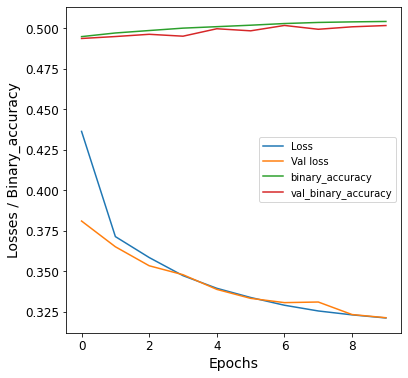

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')

plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')

plt.xlabel('Epochs')
plt.ylabel('Losses / Binary_accuracy')

plt.legend()
plt.show()

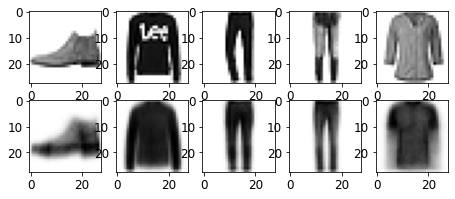

In [ ]:
# Plot the reconstructed images
show_reconstructions(l1_autoencoder, images=X_test)
plt.show()

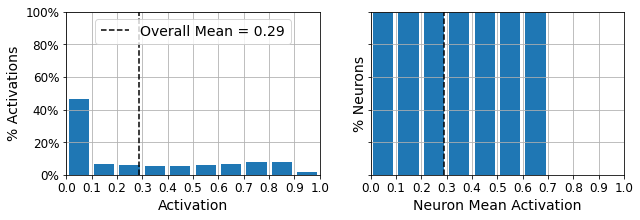

In [ ]:
plot_activations_histogram(l1_autoencoder, height=1.)
plt.show()

## Let's use the KL Divergence loss instead to ensure sparsity, and target 10% sparsity rather than 0%

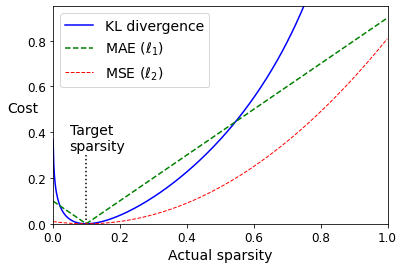

In [ ]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
# save_fig("sparsity_loss_plot")
plt.show()

In [ ]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
  def __init__(self, weight, target=0.1):
    self.weight = weight
    self.target = target
  def __call__(self, inputs):
    mean_activities = K.mean(inputs, axis=0)
    return self.weight * (kl_divergence(self.target, mean_activities) + kl_divergence(1. - self.target, 1. - mean_activities))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

# KL Divergence Regularizer
kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)

sparse_kl_encoder = Sequential()
sparse_kl_encoder.add( Flatten(input_shape=[28,28]) )
sparse_kl_encoder.add( Dense(100, activation='selu') )
sparse_kl_encoder.add( Dense(300,activation='sigmoid', activity_regularizer=kld_reg) )


sparse_kl_decoder = Sequential()
sparse_kl_decoder.add( Dense(100, activation='selu', input_shape=[300]) )
sparse_kl_decoder.add( Dense(28*28, activation='sigmoid') )
sparse_kl_decoder.add( Reshape([28, 28]) )


sparse_kl_autoencoder = Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_autoencoder.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=1.0), metrics=['binary_accuracy'])

In [ ]:
history = sparse_kl_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.4820 - binary_accuracy: 0.4869 - val_loss: 0.3726 - val_binary_accuracy: 0.4929
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3643 - binary_accuracy: 0.4975 - val_loss: 0.3482 - val_binary_accuracy: 0.4961
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3402 - binary_accuracy: 0.5012 - val_loss: 0.3325 - val_binary_accuracy: 0.4989
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3266 - binary_accuracy: 0.5039 - val_loss: 0.3223 - val_binary_accuracy: 0.5013
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3199 - binary_accuracy: 0.5041 - val_loss: 0.3187 - val_binary_accuracy: 0.5016
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3154 - binary_accuracy: 0.5052 - val_loss: 0.3153 - val_binary_accuracy: 0.5026
Epoch 7/10
1563/1563 [==============================

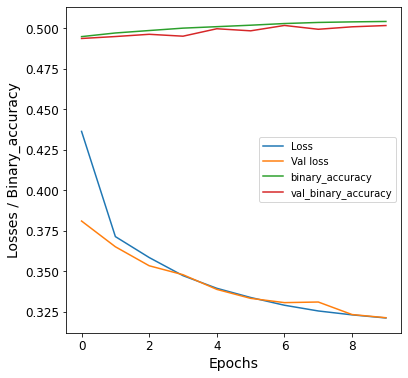

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')

plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')

plt.xlabel('Epochs')
plt.ylabel('Losses / Binary_accuracy')

plt.legend()
plt.show()

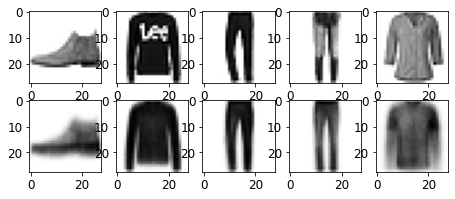

In [ ]:
# Plot the reconstructed images
show_reconstructions(sparse_kl_autoencoder, images=X_test)
plt.show()

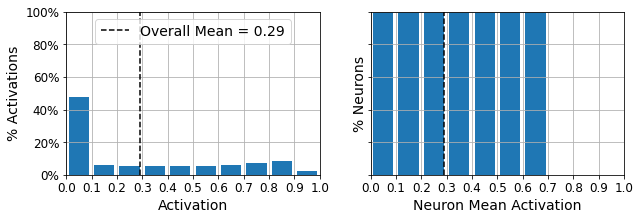

In [ ]:
plot_activations_histogram(sparse_kl_autoencoder)
plt.show()

# Variational Autoencoder

Another important category of autoencoders was introduced in 2013 by Diederik Kingma and Max Welling and quickly became one of the most popular types of autoencoders: variational autoencoders.

They are quite different from all the autoencoders we have discussed so far, in these particular ways:

- They are probabilistic autoencoders, meaning that their outputs are partly determined by chance, even after training (as opposed to denoising autoencoders, which use randomness only during training).

- Most importantly, they are generative autoencoders, meaning that they can generate new instances that look like they were sampled from the training set.

Both these properties make them rather similar to RBMs ( restricted Boltzmann machine), but they are easier to train, and the sampling process is much faster (with RBMs you need to wait for the network to stabilize into a “thermal equilibrium” before you can sample a new instance). Indeed, as their name suggests, variational autoencoders perform variational Bayesian inference, which is an efficient way to perform approximate Bayesian inference.

What is a variational autoencoder? It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

How does a variational autoencoder work?

First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma.

Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor.

Finally, a decoder network maps these latent space points back to the original input data.


**So, INPUT -> ENCODER -> (Z_mean, Z_log_sigma) -> Latent Normal Distribution (z = z_mean + exp(z_log_sigma) * epsilon) -> Decoder -> reconstructed data**

The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

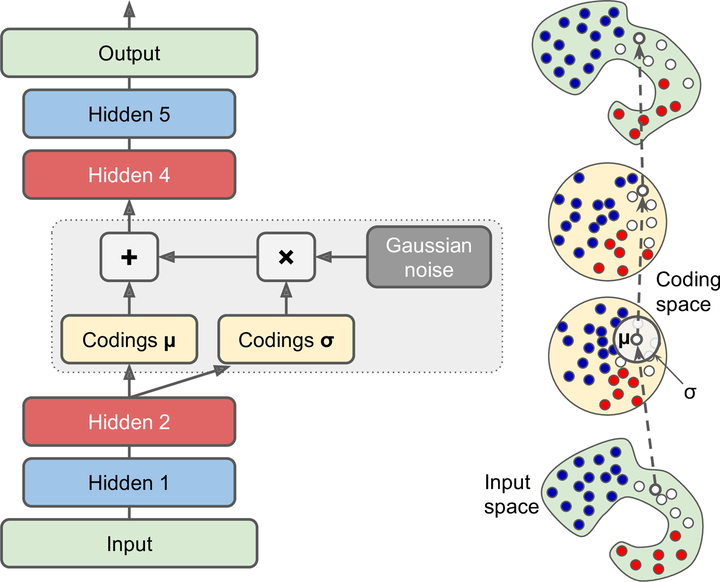

Let’s start building a variational autoencoder for Fashion MNIST. First, we will need a custom layer to sample the codings, given μ and γ:

In [ ]:
class Sampling(keras.layers.Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

This Sampling layer takes two inputs: mean (μ) and log_var (γ). It uses the function K.random_normal() to sample a random vector (of the same shape as γ) from the Normal distribution, with mean 0 and standard deviation 1. Then it multiplies it by exp(γ / 2) (which is equal to σ, as you can verify because γ = log(σ**2)), and finally it adds μ and returns the result. This samples a codings vector from the Normal distribution with mean μ and standard deviation σ.

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = Input(shape=[28, 28])
z = Flatten()(inputs)
z = Dense(150, activation='selu')(z)
z = Dense(100, activation='selu')(z)
codings_mean = Dense(codings_size)(z)
codings_log_var = Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = Input(shape=[codings_size])
x = Dense(100, activation='selu')(decoder_inputs)
x = Dense(150, activation='selu')(x)
x = Dense(28 * 28, activation='sigmoid')(x)
outputs = Reshape([28, 28])(x)
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)

variational_ae.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['binary_accuracy'])

In [ ]:
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128, validation_data=(X_valid, X_valid))

Epoch 1/25
391/391 [==============================] - 5s 7ms/step - loss: 0.4484 - binary_accuracy: 0.4794 - val_loss: 0.3633 - val_binary_accuracy: 0.5014
Epoch 2/25
391/391 [==============================] - 2s 5ms/step - loss: 0.3487 - binary_accuracy: 0.5028 - val_loss: 0.3367 - val_binary_accuracy: 0.5001
Epoch 3/25
391/391 [==============================] - 2s 5ms/step - loss: 0.3356 - binary_accuracy: 0.5048 - val_loss: 0.3429 - val_binary_accuracy: 0.5034
Epoch 4/25
391/391 [==============================] - 2s 6ms/step - loss: 0.3293 - binary_accuracy: 0.5059 - val_loss: 0.3285 - val_binary_accuracy: 0.5024
Epoch 5/25
391/391 [==============================] - 2s 5ms/step - loss: 0.3265 - binary_accuracy: 0.5053 - val_loss: 0.3299 - val_binary_accuracy: 0.5015
Epoch 6/25
391/391 [==============================] - 2s 6ms/step - loss: 0.3235 - binary_accuracy: 0.5060 - val_loss: 0.3241 - val_binary_accuracy: 0.5030
Epoch 7/25
391/391 [==============================] - 2s 6ms/ste

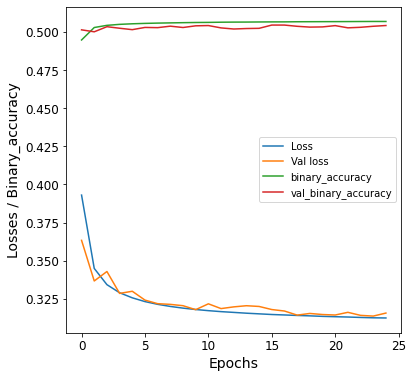

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')

plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')

plt.xlabel('Epochs')
plt.ylabel('Losses / Binary_accuracy')

plt.legend()
plt.show()

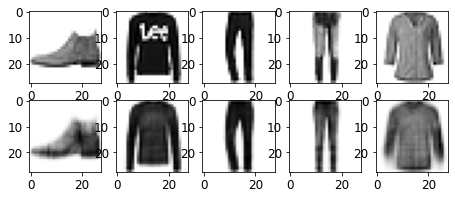

In [ ]:
# Plot the reconstructed images
show_reconstructions(variational_ae, images=X_test)
plt.show()

# Generating Fashion MNIST Images

Now let’s use this variational autoencoder to generate images that look like fashion items. All we need to do is sample random codings from a Gaussian distribution and decode them:

In [ ]:
def plot_multiple_images(images, n_cols=None):
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1
  
  if images.shape[-1] == 1:
    images = np.squeeze(images, axis=-1)
  
  plt.figure(figsize=(n_cols, n_rows))
  
  for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

Let's generate a few random codings, decode them and plot the resulting images:

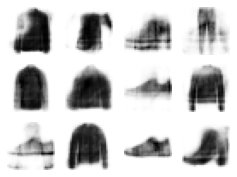

In [ ]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

Now let's perform semantic interpolation between these images:

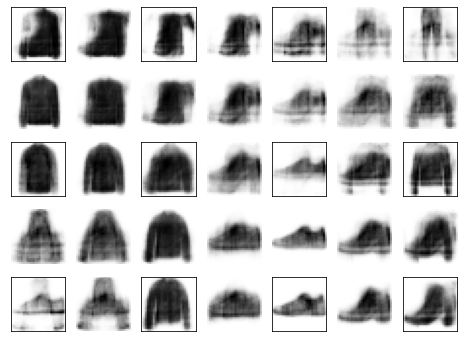

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(8, 6))
for index, image in enumerate(images):
  plt.subplot(5, 7, index + 1)
  if index%7%2==0 and index//7%2==0:
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
  else:
    plt.axis('off')
  
  plt.imshow(image, cmap='binary')
plt.show()  

The original images are framed, and the rest are the result of semantic interpolation between the nearby images. Notice, for example, how the shoe in the fourth row and fifth column is a nice interpolation between the two shoes located above and below it.

# Variational Autoencoder with MNIST digits

## MNIST digit dataset

We will use the original MNIST digits with shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1.

In [ ]:
import keras
from keras import Model
from keras import backend as K
from keras.layers import Lambda, Input, Dense, Flatten, Reshape

In [ ]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
print('X_train_full.shape: ', x_train.shape)
print('y_train_full.shape: ', y_train.shape)
print('X_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)

X_train_full.shape:  (60000, 784)
y_train_full.shape:  (60000,)
X_test.shape:  (10000, 784)
y_test.shape:  (10000,)


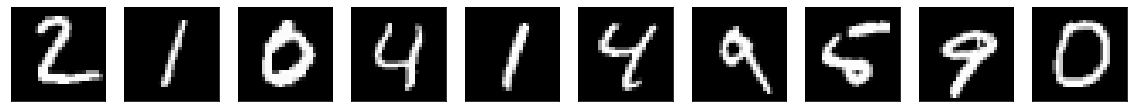

In [ ]:
# Plot some samples
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
  # Display original
  ax = plt.subplot(1, n, i)
  plt.imshow(x_test[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Model

First, here's our encoder network, mapping inputs to our latent distribution parameters:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)

# Coding mean
z_mean = Dense(latent_dim)(h)
# Coding sigma
z_log_sigma = Dense(latent_dim)(h)

We can use these parameters to sample new similar points from the latent space:

In [ ]:
def sampling(args):
  z_mean, z_log_sigma = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
  return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling)([z_mean, z_log_sigma])

In [ ]:
# Create encoder
encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 64)           50240       input_5[0][0]                    
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 2)            130         dense_17[0][0]                   
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 2)            130         dense_17[0][0]                   
____________________________________________________________________________________________

In [ ]:
# Create decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_21 (Dense)             (None, 784)               50960     
Total params: 51,152
Trainable params: 51,152
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2]) # encoder(inputs) -> [z_mean, z_log_sigma, z]
vae = Model(inputs, outputs, name='vae_mlp')

In [ ]:
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 50500     
_________________________________________________________________
decoder (Functional)         (None, 784)               51152     
Total params: 101,652
Trainable params: 101,652
Non-trainable params: 0
_________________________________________________________________


What we've done so far allows us to instantiate 3 models:

- an end-to-end autoencoder mapping inputs to reconstructions
- an encoder mapping inputs to the latent space
- a generator that can take points on the latent space and will output the corresponding reconstructed samples.

We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

In [ ]:
# reconstruction loss
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim

# KL divergence regularization term
kl_loss = 1. + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

# Sum of the losses
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Compile
vae.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [ ]:
history = vae.fit(x_train, x_train, epochs=100, batch_size=32, validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 7s 3ms/step - loss: 221.2878 - binary_accuracy: 0.7863 - val_loss: 169.5590 - val_binary_accuracy: 0.7953
Epoch 2/100
1875/1875 [==============================] - 5s 3ms/step - loss: 168.4813 - binary_accuracy: 0.7967 - val_loss: 164.2025 - val_binary_accuracy: 0.7936
Epoch 3/100
1875/1875 [==============================] - 5s 3ms/step - loss: 163.5482 - binary_accuracy: 0.7956 - val_loss: 161.0698 - val_binary_accuracy: 0.7949
Epoch 4/100
1875/1875 [==============================] - 5s 3ms/step - loss: 161.1396 - binary_accuracy: 0.7950 - val_loss: 159.2916 - val_binary_accuracy: 0.7950
Epoch 5/100
1875/1875 [==============================] - 5s 3ms/step - loss: 158.5723 - binary_accuracy: 0.7962 - val_loss: 157.7798 - val_binary_accuracy: 0.7952
Epoch 6/100
1875/1875 [==============================] - 5s 3ms/step - loss: 157.9943 - binary_accuracy: 0.7954 - val_loss: 156.8586 - val_binary_accuracy: 0.7958
Epoch 7/100
1875/1875 

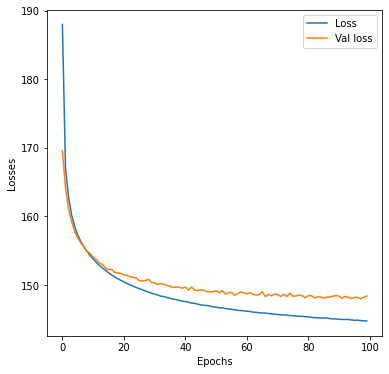

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')

plt.xlabel('Epochs')
plt.ylabel('Losses')

plt.legend()
plt.show()

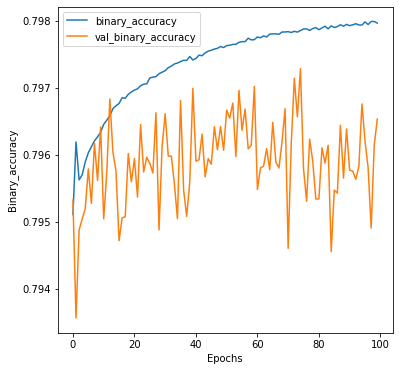

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')

plt.xlabel('Epochs')
plt.ylabel('Binary_accuracy')

plt.legend()
plt.show()

## Results

In [ ]:
# Predict using X_test
batch_size = 32
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

In [ ]:
x_test_encoded

[array([[ 4.5468339e-01,  4.1556555e-01],
        [-3.5814008e-01, -5.2490062e-01],
        [ 2.4127141e-01,  2.0296202e+00],
        ...,
        [ 3.2486257e-01,  3.4828931e-01],
        [-3.8873911e-02,  2.9483110e-02],
        [ 4.6887994e-04, -3.9407903e-01]], dtype=float32),
 array([[-1.73756   , -1.7810568 ],
        [-1.7306879 , -1.695294  ],
        [-1.214038  , -0.57768416],
        ...,
        [-1.7296172 , -1.6559169 ],
        [-1.8114954 , -1.8733994 ],
        [-1.9760715 , -1.9202133 ]], dtype=float32),
 array([[ 0.4348813 ,  0.38395005],
        [-0.34658974, -0.49875918],
        [ 0.19765961,  2.0404627 ],
        ...,
        [ 0.3265    ,  0.34868687],
        [-0.03592803,  0.01840606],
        [ 0.01936147, -0.3747835 ]], dtype=float32)]

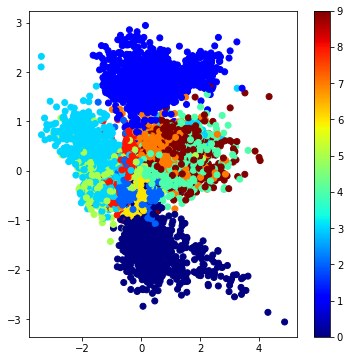

In [ ]:
x_test_encoded = x_test_encoded[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='jet')
plt.colorbar()
plt.show()

In [ ]:
# Predict using X_test
batch_size = 32
x_test_encoded = vae.predict(x_test, batch_size=batch_size)

In [ ]:
len( x_test_encoded )

10000

In [ ]:
x_test_encoded

array([[3.2088961e-13, 2.5144578e-13, 3.7544002e-13, ..., 3.9744022e-13,
        3.7776732e-13, 4.4159834e-13],
       [1.5887428e-17, 6.2111040e-17, 6.4681176e-17, ..., 7.1326474e-17,
        3.2770821e-17, 1.4883532e-16],
       [6.1007386e-24, 3.2629999e-24, 6.0453239e-24, ..., 1.3597389e-23,
        1.3139936e-23, 3.8822780e-23],
       ...,
       [2.8970725e-13, 2.9638236e-13, 4.5216966e-13, ..., 4.8601395e-13,
        4.0570130e-13, 5.6922967e-13],
       [3.7528730e-14, 8.1176012e-14, 1.1903903e-13, ..., 1.1353974e-13,
        7.0095514e-14, 1.7362513e-13],
       [6.0532443e-15, 1.7715352e-14, 1.5847353e-14, ..., 1.4900190e-14,
        8.2362358e-15, 2.4468107e-14]], dtype=float32)

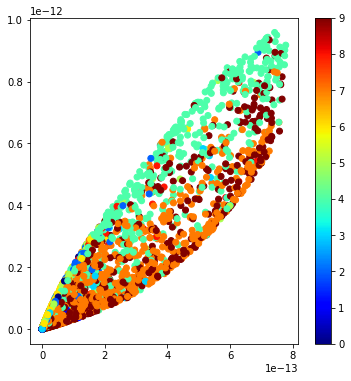

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='jet')
plt.colorbar()
plt.show()

Each of these colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).

Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

In [ ]:
print( grid_x.shape )
print( grid_y.shape )

(15,)
(15,)


In [ ]:
for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    x_decoded = decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

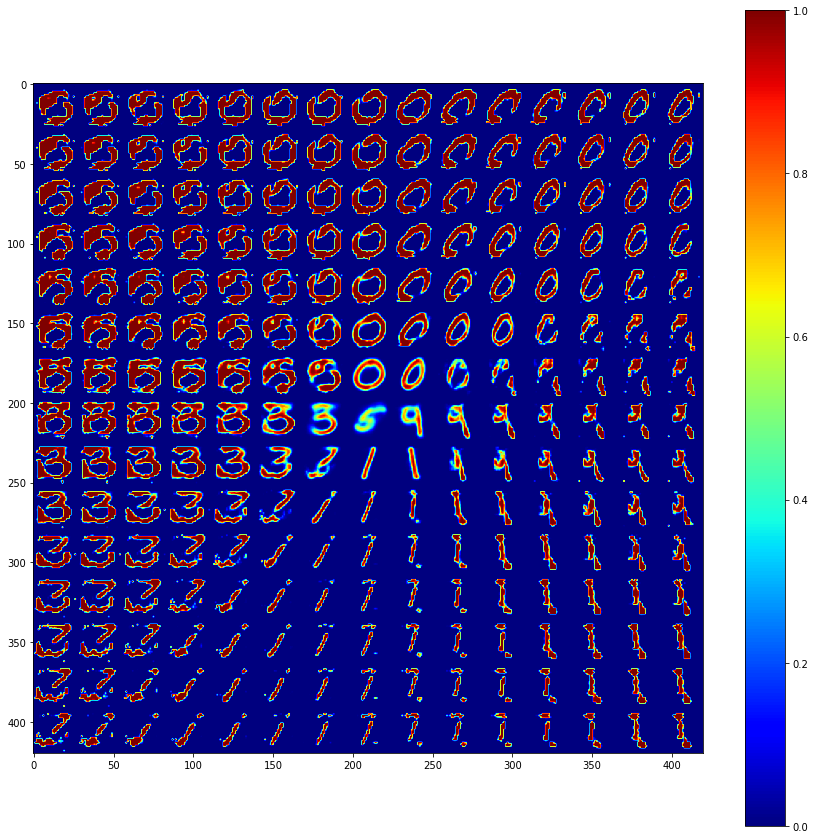

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='jet')
plt.colorbar()
plt.show()